# Demand Unconstraining Using Expectation-Maximization (EM)

This notebook is a tutorial on using Expectation-Maximization (EM) for demand unconstraining. The concept was first intorduced in [1], and this implementation mainly follows the description in [2].

1. J. Salch, "Unconstraining passenger demand using the EM algorithm," in Proceedings of the INFORMS Conference, Dallas, Tex, USA, 1997. 
2. K. Talluri and G. van Ryzin, “Revenue management under a general discrete choice model of consumer behavior,” Management Science, vol. 50, no. 1, pp. 15–33, 2004.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import platform
print(f'Python {platform.python_version()}')

Python 3.9.13


## Data Sample

We use a simple demand time series with just 18 samples (time steps). For each time step, there is a pair of the demand and capacity values. The demand cannot exceed the capacity, so the samples where the demand equals capacity are considered as constrained (aka censored or out-of-stock events). 

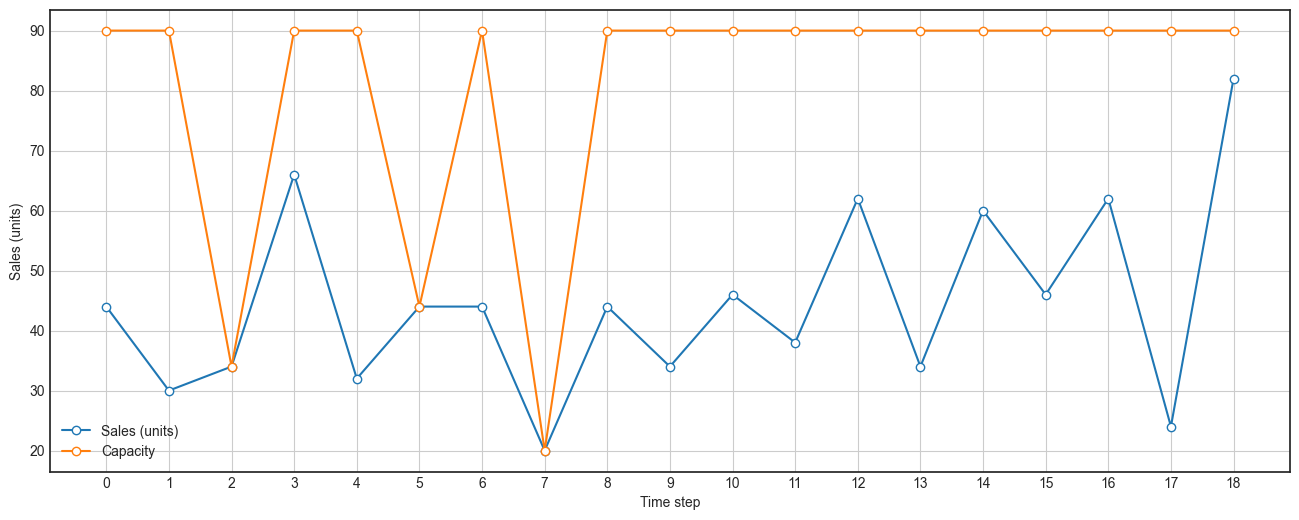

In [2]:
data = pd.DataFrame([
[44, 90],
[30, 90],
[34, 34], # constrained
[66, 90],
[32, 90],
[44, 44], # constrained
[44, 90],
[20, 20], # constrained
[44, 90],
[34, 90],
[46, 90],
[38, 90],
[62, 90],
[34, 90],
[60, 90],
[46, 90],
[62, 90],
[24, 90],
[82, 90]
], columns=['demand', 'capacity'], dtype=float)

data['demand2'] = np.power(data.demand, 2)

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('Time step')
ax.set_xticks(range(len(data)))
ax.set_ylabel('Sales (units)')
ax.plot(data.demand, label='Sales (units)', marker='o', markerfacecolor='white')
ax.grid(True)
ax.plot(data.capacity, label='Capacity', marker='o', markerfacecolor='white')
ax.legend()
plt.show()

## Expectation-Maximization

We unconstrain the censored samples using the EM algorithm assuming that the demand samples are normally distributed. The plot shows that the algorithm converges to stable values in a just a few iterations.

44.526315789473685 15.788070113054884
47.51017694118935 15.211551316747475
47.72562881739299 14.966148356626936
47.72359626250214 14.958575220760789
47.722786299209076 14.951555155268586


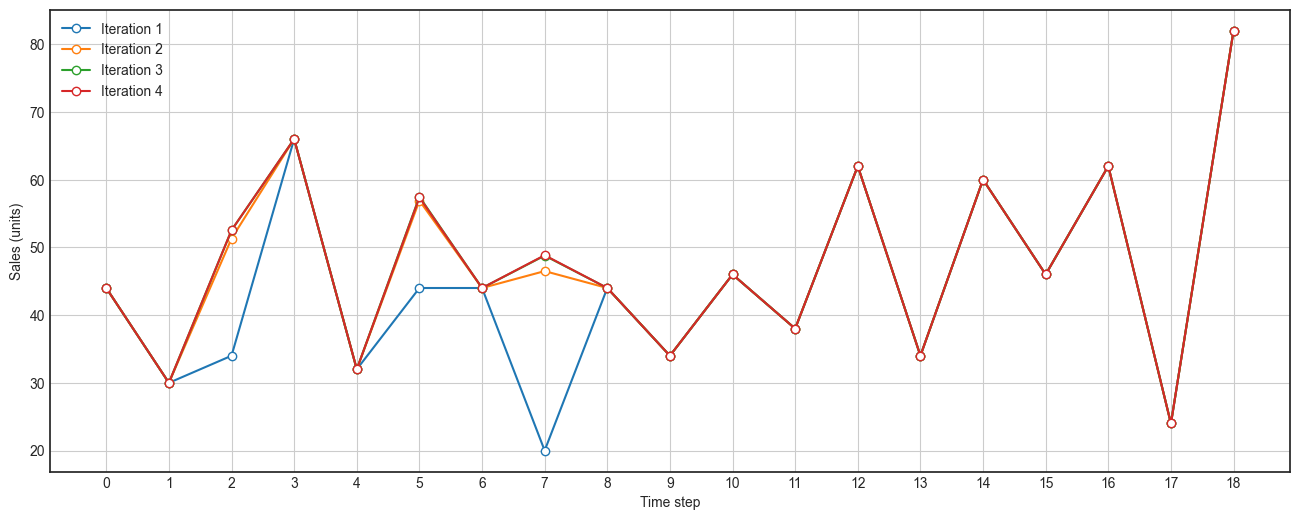

In [3]:
def sample_normal_bounded(mu, sigma, c):
    n = 100000
    x = np.random.normal(mu, sigma, n)
    return x[x >= c]

#
# Initialization
#
demand_mean = data.demand.mean()
demand_std = data.demand.std()
print(demand_mean, demand_std)

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('Time step')
ax.set_xticks(range(len(data)))
ax.set_ylabel('Sales (units)')
ax.grid(True)

d = data.copy()

#
# Expectation-maximization loop
#
for em_step in range(1, 5):
    plt.plot(d.demand, label=f'Iteration {em_step}', marker='o', markerfacecolor='white')
    
    # Expectation step
    for i in range(len(data)):
        if d.demand.iloc[i] >= d.capacity.iloc[i]:
            d.demand.iloc[i] = np.mean(sample_normal_bounded(demand_mean, demand_std, d.capacity.iloc[i]))
            d.demand2.iloc[i] = np.mean(np.power(sample_normal_bounded(demand_mean, demand_std, d.capacity.iloc[i]), 2))
        
    # Maximization step
    demand2_sum = 0
    for i in range(len(data)):
        if d.demand.iloc[i] >= d.capacity.iloc[i]:
            demand2_sum += d.demand2.iloc[i] - 2*d.demand.iloc[i]*demand_mean + np.power(demand_mean, 2)
        else:
            demand2_sum += np.power(data.demand.iloc[i] - demand_mean, 2)
    demand_std = np.sqrt(demand2_sum / len(d))
    
    demand_mean = d.demand.mean()
    
    print(demand_mean, demand_std)

ax.legend()
plt.show()